In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [2]:

from tensorflow.keras.datasets import cifar10
train_ds, test_ds = cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((train_ds[0], train_ds[1]))


In [3]:

def show_images(images):
    n = len(images)
    for i, image in enumerate(images):
        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()


In [4]:

IMG_SIZE = 32
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1/255)  # corrected from 1/256 to 1/255
])


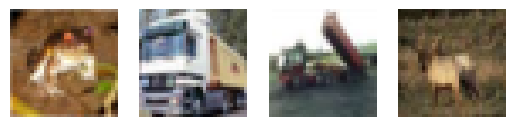

In [5]:

resized_images = train_ds.take(4).map(lambda x, y: resize_and_rescale(x))
resized_images_list = [img.numpy() for img in resized_images]
show_images(resized_images_list)

data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(factor=.2),
    tf.keras.layers.RandomContrast(factor=(.2, .9))
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


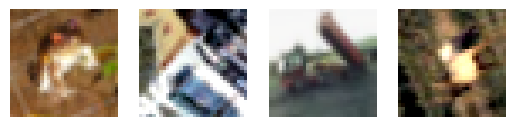

In [6]:

aug_images = resized_images.map(lambda x: data_augumentation(x))
aug_images_list = [img.numpy() for img in aug_images]
show_images(aug_images_list)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


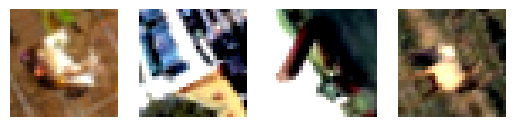

In [7]:

AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds):
    ds = ds.map(lambda x, y:
                (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y:
                (data_augumentation(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

prepared_ds = prepare(train_ds.take(4))
prepared_images = [img.numpy() for img, _ in prepared_ds]
show_images(prepared_images)


Method 2

In [8]:

image, label = next(iter(train_ds))


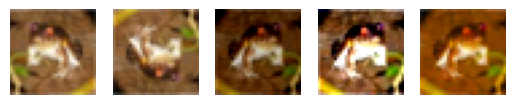

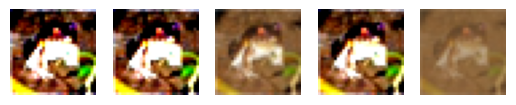

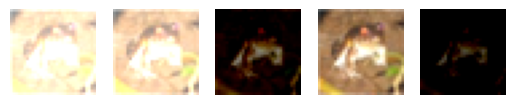

In [9]:

show_images([
    tf.image.flip_left_right(image).numpy(),
    tf.image.flip_up_down(image).numpy(),
    tf.image.adjust_brightness(image, -.2).numpy(),
    tf.image.adjust_contrast(image, 2).numpy(),
    tf.image.adjust_saturation(image, 2).numpy(),
])
show_images([
    tf.image.stateless_random_contrast(image, lower=.1, upper=5, seed=(i, 0)).numpy()
    for i in range(1, 6)
])
show_images([
    tf.image.stateless_random_brightness(image, max_delta=.8, seed=(i, 0)).numpy()
    for i in range(1, 6)
])


In [10]:

def resize_and_rescale(img):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (32, 32))
    img = img / 255.0
    return img

def augment(img_label, seed):
    image, label = img_label
    image = resize_and_rescale(image)
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label


In [11]:

rng = tf.random.Generator.from_seed(1, alg="philox")


In [12]:

def augment_wrapper(image, label):
    seed = rng.make_seeds(2)[0]
    image, label = augment((image, label), seed)
    return image, label


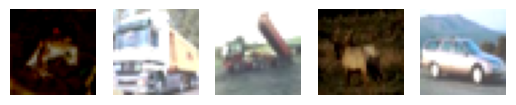

In [13]:

augmented_ds = train_ds.take(5).map(augment_wrapper)
augmented_images = [img.numpy() for img, _ in augmented_ds]
show_images(augmented_images)
